# 00_1_DESIGN_Homologs

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/00_1_DESIGN_Homologs.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture
!pip install pydna
!pip install constrain
!pip install matplotlib
!pip install Bio

In [12]:
from Bio.Blast import NCBIWWW
from Bio.Seq import Seq
from Bio import SeqIO
blast = True
import pathlib
from Bio.Blast import NCBIXML
import pandas as pd

## 1. Intro

This notebook is made to be able to find homologs from protein queries. As a **test case** the G8H step in the Strictosidine pathway was chosen.  

**Some background on Strictosidine:** 
Strictosidine is a precurser for several anti-cancer compounds and is interesting because it is extracted from plants and due to weather and agricultural pests yields vary year to year (Brown et al., 2015). Additionally, Strictosidine is difficult to chemically synthesisze. Therefore we want to take the prouction to a yeast cell factory. However, the G8H (cytochrome p450) part of the pathway is the limiting step of the pathway and we want to optimize that via combinatorial optimizition. We have therefore chosen this step as test case for developing algorithms that can standardize homolog selection. The pathway is shown below.

This notebook has been developed to answer the following question:

**Can we via algorithms determine and standardize homolog selection?** 



In [3]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


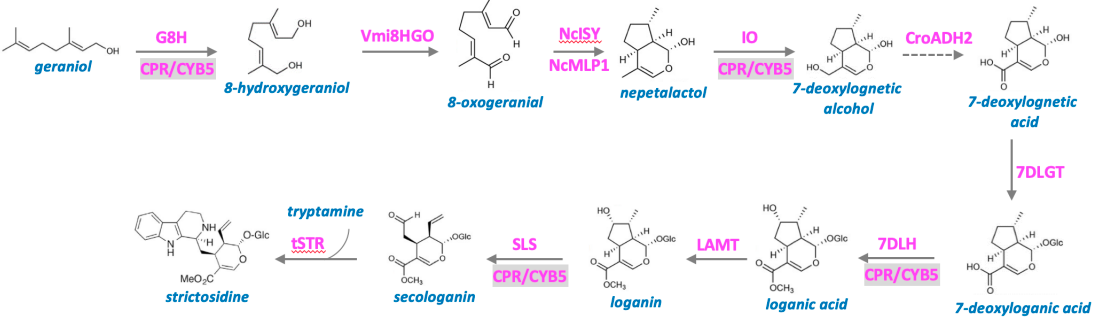

In [4]:
from IPython import display
display.Image('ConStrain_on_google_colab/pictures/Strictosidine_pathway.png')

**Main objective:**

- Finding Homologs for G8H, a major bottleneck in the Strictosidine pathway. More specifically two groups: 
    - G8H-CYP (Cytochrome p450)
    - G8H-CPR (Cytochrome p450 reductase)
    

**The method/algorithm for finding the set of homologs is described as follows:**

1. Read in the protein sequence of interest
2. BLAST the sequence with the Biopython NCBIWWW.qblast function and select “blastp”. 
3. Search through the newly generated alignment XML file and find proteins that fit your parameters and save ACC numbers. Parameters included here are: 
    - Identity: 70-95% 
    - E-value threshold 0.04
4. The ACC numbers are then used for fetching the protein sequences and saved as a FASTA file. 
5. The protein sequences are then made into DNA sequences in a 2 step process.
6. A temporary DNA sequence is made from a translation table
7. Codon optimized with “DNA chisel” for the organism of choice.
8. The codon-optimized sequences are made into Biopython SeqRecord objects and can be: 
    - Exported to a database of choice through an API (Benchling, Teselagen)
    - Saved as a FASTA file. 


## 2. G8H BLAST

#### First we make a file path for the fasta file we want to blast

In [5]:
p = 'ConStrain_on_google_colab/Data/Protein_seqs/Q8VWZ7.FASTA'
pathCroG8H = pathlib.Path(p).resolve()
pathCroG8H

PosixPath('/Users/lucaslevassor/projects/ConStrain/colab_notebooks/ConStrain_on_google_colab/Data/Protein_seqs/Q8VWZ7.FASTA')

#### Then we read it into a Seqrecord object with biopython

In [6]:
croG8H = SeqIO.read(pathCroG8H, format="fasta")
croG8H


SeqRecord(seq=Seq('MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSL...STL'), id='sp|Q8VWZ7|C76B6_CATRO', name='sp|Q8VWZ7|C76B6_CATRO', description='sp|Q8VWZ7|C76B6_CATRO Geraniol 8-hydroxylase OS=Catharanthus roseus OX=4058 GN=CYP76B6 PE=1 SV=1', dbxrefs=[])

In [7]:
print('LENGTH OF THE PROTEIN: ',len(croG8H.seq))
print(croG8H.seq)

LENGTH OF THE PROTEIN:  493
MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSLAKLSKKHGPIMSLKLGQITTIVISSSTMAKEVLQKQDLAFSSRSVPNALHAHNQFKFSVVWLPVASRWRSLRKVLNSNIFSGNRLDANQHLRTRKVQELIAYCRKNSQSGEAVDVGRAAFRTSLNLLSNLIFSKDLTDPYSDSAKEFKDLVWNIMVEAGKPNLVDFFPLLEKVDPQGIRHRMTIHFGEVLKLFGGLVNERLEQRRSKGEKNDVLDVLLTTSQESPEEIDRTHIERMCLDLFVAGTDTTSSTLEWAMSEMLKNPDKMKKTQDELAQVIGRGKTIEESDINRLPYLRCVMKETLRIHPPVPFLIPRKVEQSVEVCGYNVPKGSQVLVNAWAIGRDETVWDDALAFKPERFMESELDIRGRDFELIPFGAGRRICPGLPLALRTVPLMLGSLLNSFNWKLEGGMAPKDLDMEEKFGITLQKAHPLRAVPSTL


### 2.1 Blasting it on NCBI

In [93]:
%%time
result_handle = NCBIWWW.qblast("blastp", "nr", sequence=croG8H,  hitlist_size=3000) # format_type='Text',

CPU times: user 755 ms, sys: 135 ms, total: 890 ms
Wall time: 15min 10s


#### 2.1.1 Write the blast onto an XML file 

In [94]:
blast_result = open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_homologs.xml", "w")
blast_result.write(result_handle.read())
blast_result.close()
result_handle.close()

#### 2.1.2 Open the generated file and read it into a variable 

In [95]:
from Bio.Blast import NCBIXML

with open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_homologs.xml", "r") as result_handle:
    blast_record = NCBIXML.read(result_handle)

#### 2.1.3. Filter BLAST results, on E-value, percentage protein identity

In [96]:
E_VALUE_THRESH = 0.4
LOWER_PROTEIN_IDENTITY_THRESH = 0.1
UPPER__PROTEIN_IDENTITY_THRESH = 0.99999
Alignments_that_follow_our_criteria = [] #These are the ACC numbers

# saving some of the metrics
Names = []
Identity = []
E_value = []
Length = []
ACC_number = []

counter = 0
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        IDENTITY = (hsp.identities/ hsp.align_length)
        if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH:
            counter += 1
            #print("\nAlignment#", counter)
            #print("Name:", alignment.hit_def)
            #print("Title:", alignment.title)
            #print("Length:", alignment.length)
            #print("E value:", hsp.expect)
            #print('Query:', hsp.query[0:75] + "...")
            #print('Match:', hsp.match[0:75] + "...")
            #print('Subjt:',hsp.sbjct[0:75] + "...")
            #print('Identitiy', "{:.2f}".format(IDENTITY))
            #print(alignment)
            #
            # Saving the metrics we want into different lists
            Alignments_that_follow_our_criteria.append(alignment)
            Names.append(alignment.hit_def)
            Identity.append(IDENTITY)
            E_value.append(hsp.expect)
            Length.append(alignment.length)
            ACC_number.append(alignment.accession)
            
print('\nTOTAL HOMOLOGS', counter)


TOTAL HOMOLOGS 3060


#### 2.1.4 Display results in a pandas dataframe 

Note: The alignments are saved onto a Bio.Blast.Record.Alignment datatype

In [97]:
Alignments_that_follow_our_criteria[0].hit_def

'RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >gb|KAI5665891.1| hypothetical protein M9H77_15744 [Catharanthus roseus] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]'

In [98]:
import pandas as pd

In [99]:
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", 100)


In [100]:
data = list(zip(Names,Identity, E_value, Length, ACC_number))
df_alignments_that_follow_our_criteria = pd.DataFrame(data, columns=['Name','Identity', 'E_value', 'Length', 'ACC_number'])

# Sort dataframe  
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria.sort_values(by='Identity', ascending=False)
print(len(df_alignments_that_follow_our_criteria))
df_alignments_that_follow_our_criteria.head(10)

3060


,Name,Identity,E_value,Length,ACC_number
0,RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >gb|KAI5665891.1| hypothetical protein M9H77_15744 [Catharanthus roseus] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus],0.964912,3.282570e-27,493,Q8VWZ7
410,unnamed protein product [Cuscuta campestris],0.787879,5.995810e-06,501,VFQ92048
939,"hypothetical protein EJB05_12157, partial [Eragrostis curvula]",0.785714,2.820460e-04,538,TVU38771
106,cytochrome P450 [Cynara cardunculus var. scolymus],0.781250,7.172810e-08,1170,KVI02662
1564,unnamed protein product [Digitaria exilis],0.777778,2.134790e-03,503,CAB3499145
1479,hypothetical protein HU200_007505 [Digitaria exilis],0.777778,1.694910e-03,332,KAF8768561
909,hypothetical protein M758_5G064800 [Ceratodon purpureus],0.758621,2.514100e-04,535,KAG0615761
903,hypothetical protein KC19_5G065800 [Ceratodon purpureus],0.758621,2.420690e-04,535,KAG0576240
732,hypothetical protein M8C21_013309 [Ambrosia artemisiifolia],0.758621,1.208190e-04,492,KAI7737101
777,hypothetical protein F8388_016149 [Cannabis sativa] >gb|KAF4390134.1| hypothetical protein G4B88_005052 [Cannabis sativa],0.758621,1.504000e-04,478,KAF4370412


We need to narrow down the candidtates. One way to do this is to select is to take a range of amino acid identeties. another way is to limit the length to be more similar to the native enzyme


In [101]:
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria[ df_alignments_that_follow_our_criteria['Length'] > len(croG8H)-50]
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria[ df_alignments_that_follow_our_criteria['Length'] <len(croG8H)+50]
len(df_alignments_that_follow_our_criteria)

2249

In [102]:
# Sorting the dataframe
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria.sort_values(by='Identity', ascending=False)
df_alignments_that_follow_our_criteria

,Name,Identity,E_value,Length,ACC_number
0,RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >gb|KAI5665891.1| hypothetical protein M9H77_15744 [Catharanthus roseus] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus],0.964912,3.282570e-27,493,Q8VWZ7
410,unnamed protein product [Cuscuta campestris],0.787879,5.995810e-06,501,VFQ92048
939,"hypothetical protein EJB05_12157, partial [Eragrostis curvula]",0.785714,2.820460e-04,538,TVU38771
1564,unnamed protein product [Digitaria exilis],0.777778,2.134790e-03,503,CAB3499145
909,hypothetical protein M758_5G064800 [Ceratodon purpureus],0.758621,2.514100e-04,535,KAG0615761
...,...,...,...,...,...
2022,CYP76AD3/P450 tyrosinase fusion protein [Expression vector pWCD2111],0.338983,5.417210e-03,498,AKH61558
1988,CYP76AD3/P450 tyrosinase fusion protein [Expression vector pWCD2107],0.338983,5.167780e-03,498,AKH61574
1857,cytochrome P450 71A1 [Populus trichocarpa],0.337838,3.966440e-03,515,XP_024443158
1904,hypothetical protein XELAEV_18028179mg [Xenopus laevis],0.327586,4.334510e-03,487,OCT81361


In [103]:
lst_of_hits = list(df_alignments_that_follow_our_criteria['ACC_number'])
if 'AES93118' in lst_of_hits: 
    print('Yes')
else: 
    print('lort')

lort


#### 2.1.5 Choosing homologs



The idea is to create a diverse library. Therefore I chose the following homologs with AA identeties ranging from our query to 66.6% AA identity.

In [66]:
chosen_homologs = ['Q8VWZ7','AGX93055','AGX93051' ,'AGX93053' , 'BAP90522', 'XP_022858342', 'D1MI46','AES93118', ]

#'AES93118' - CacuG8H

In [67]:
chosen_homologs_df = df_alignments_that_follow_our_criteria[df_alignments_that_follow_our_criteria['ACC_number'].isin(chosen_homologs)]
print(len(chosen_homologs_df))
chosen_homologs_df

7


,Name,Identity,E_value,Length,ACC_number
0,RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >gb|KAI5665891.1| hypothetical protein M9H77_15744 [Catharanthus roseus] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus],0.964912,3.274450e-27,493,Q8VWZ7
3,geraniol 10-hydroxylase-like protein [Rauvolfia serpentina],0.754386,5.123990e-20,493,AGX93053
4,geraniol 10-hydroxylase-like protein [Cinchona calisaya],0.754386,1.318650e-19,493,AGX93051
10,geraniol 8-hydroxylase-like [Olea europaea var. sylvestris],0.736842,1.466650e-18,494,XP_022858342
145,geraniol 10-hydroxylase-like protein [Vinca minor],0.719298,6.581610e-08,493,AGX93055
7,geraniol 10-hydroxylase [Ophiorrhiza pumila],0.704918,2.454820e-19,512,BAP90522
90,RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B10; AltName: Full=Geraniol 10-hydroxylase; Short=SmG10H [Swertia mussotii] >gb|ACZ48680.1| geraniol 10-hydroxylase [Swertia mussotii],0.666667,1.403400e-08,495,D1MI46


In [68]:
acc_numbers = chosen_homologs_df['ACC_number'].tolist()
Names_species = chosen_homologs_df['Name'].tolist()
acc_numbers

['Q8VWZ7',
 'AGX93053',
 'AGX93051',
 'XP_022858342',
 'AGX93055',
 'BAP90522',
 'D1MI46']

## 3. Retrieve the sequences and write them onto a file

### 3.1 Getting DNA sequences through Entrez 

Retrieve the sequences with the Entrez library which is possible with the ACC numbers we found before. Save the retrieved sequences as a fasta file called 'Homolog_seqs.fasta'. You need to provide an email for this so they know who you are. 

In [ ]:
from Bio import Entrez

In [ ]:
%%time

# add ur email here
email = "youremail@gmail.com"

out_handle = open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CYP_Homolog_seqs.fasta', "w")

for i in range(0, len(acc_numbers)):
    Entrez.email = email
    handle = Entrez.efetch(db="protein", id=acc_numbers[i], rettype="fasta", retmode="text")
    
    out_handle.write(handle.read())
out_handle.close()

### 3.2 Read the sequences into variables

Now parse through the file and get all the AA sequences which can be made into to DNA later. 

In [ ]:
fasta_sequences = SeqIO.parse(open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CYP_Homolog_seqs.fasta'),'fasta')
names = []
sequences = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    sequences.append(str(sequence)+'*')

print(len(sequences))

## 4. Codon optimize it for yeast

We can use DNA chisel to backtranslate the sequences and afterwards codon optimize them. 

In [ ]:
from dnachisel.biotools import reverse_translate

### First we just make a dummy dna sequece from the protein seq
protein_to_dna = []

for i in range(0, len(sequences)): 
    aa_seq = str(sequences[i])
    protein_to_dna.append(reverse_translate(aa_seq))
print(len(protein_to_dna))
print(protein_to_dna[1]) 

### 4.1 DNA chisel

Here the DNA is codon optimized for s_cerevisiae with DNA chisel

In [ ]:
### Using DNA chisel to optimize the pattern: 

from dnachisel import *

codon_optimized_seqs = []

# DEFINE THE OPTIMIZATION PROBLEM
for i in range(0, len(protein_to_dna)):
    problem = DnaOptimizationProblem(
        sequence=protein_to_dna[i], 
        constraints=[EnforceGCContent(mini=0.3, maxi=0.7)],
        objectives=[CodonOptimize(species='s_cerevisiae')]
    )

    # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE
    problem.resolve_constraints()
    problem.optimize()

    # GET THE FINAL SEQUENCE AS ANNOTATED BIOPYTHON RECORDS)
    final_record = problem.to_record(with_sequence_edits=True)
    final_record.id = acc_numbers[i]
    final_record.name = 'G8H{}'.format(i)
    final_record.description = Names_species[i]
    
    codon_optimized_seqs.append(final_record)

In [ ]:
codon_optimized_seqs

Writing the sequences into a fasta_file

In [ ]:
with open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CYP_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_seqs)):
        print(codon_optimized_seqs[i].format("fasta"), file = outfile)

## 5. CPR BLAST


- The CPR was found in the article: De novo production of the plant-derived alkaloid strictosidine in yeast, under suplementary information
- From the fasta-file we have the CPR protein sequece and then we can repeat what was done above for finding G8H homologs 

In [5]:
G8H_CPR = SeqIO.read('ConStrain_on_google_colab/Data/Protein_seqs/Q05001.1.fasta', format="fasta")
G8H_CPR

SeqRecord(seq=Seq('MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILT...DVW'), id='sp|Q05001.1|NCPR_CATRO', name='sp|Q05001.1|NCPR_CATRO', description='sp|Q05001.1|NCPR_CATRO RecName: Full=NADPH--cytochrome P450 reductase; Short=CPR; Short=P450R', dbxrefs=[])

In [6]:
print(G8H_CPR.seq)

MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILTTSVAVLIGCVVVLIWRRSSGSGKKVVEPPKLIVPKSVVEPEEIDEGKKKFTIFFGTQTGTAEGFAKALAEEAKARYEKAVIKVIDIDDYAADDEEYEEKFRKETLAFFILATYGDGEPTDNAARFYKWFVEGNDRGDWLKNLQYGVFGLGNRQYEHFNKIAKVVDEKVAEQGGKRIVPLVLGDDDQCIEDDFAAWRENVWPELDNLLRDEDDTTVSTTYTAAIPEYRVVFPDKSDSLISEANGHANGYANGNTVYDAQHPCRSNVAVRKELHTPASDRSCTHLDFDIAGTGLSYGTGDHVGVYCDNLSETVEEAERLLNLPPETYFSLHADKEDGTPLAGSSLPPPFPPCTLRTALTRYADLLNTPKKSALLALAAYASDPNEADRLKYLASPAGKDEYAQSLVANQRSLLEVMAEFPSAKPPLGVFFAAIAPRLQPRFYSISSSPRMAPSRIHVTCALVYEKTPGGRIHKGVCSTWMKNAIPLEESRDCSWAPIFVRQSNFKLPADPKVPVIMIGPGTGLAPFRGFLQERLALKEEGAELGTAVFFFGCRNRKMDYIYEDELNHFLEIGALSELLVAFSREGPTKQYVQHKMAEKASDIWRMISDGAYVYVCGDAKGMARDVHRTLHTIAQEQGSMDSTQAEGFVKNLQMTGRYLRDVW


### 5.1 Blasting on NCBI

Have already done this - if you want to try you can do it again or else move to the next cell were the results are loaded in.


In [28]:
%%time
result_handle1 = NCBIWWW.qblast("blastp", "nr", sequence = G8H_CPR.seq, hitlist_size=2500)
#
## Writing the results into an XML files so we dont have to blast every time
blast_result1 = open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs.xml", "w")
blast_result1.write(result_handle1.read())
blast_result1.close()
result_handle1.close()

CPU times: user 148 ms, sys: 100 ms, total: 248 ms
Wall time: 3min 14s


#### 5.1.1 Write the blast onto an XML file 

In [29]:
from Bio.Blast import NCBIXML

with open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs.xml", "r") as result_handle1:
    blast_record = NCBIXML.read(result_handle1)

#### 5.1.2 Filter BLAST results, on E-value, percentage protein identity

In [15]:
E_VALUE_THRESH = 0.04
LOWER_PROTEIN_IDENTITY_THRESH = 0.1
UPPER__PROTEIN_IDENTITY_THRESH = 0.99999
#AA_length_min = 704
#AA_length_max = 724
Alignments_that_follow_our_criteria1 = []

# saving the blast results
Names = []
Identity = []
E_value = []
Length = []
ACC_number = []

counter = 0
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        IDENTITY = (hsp.identities/ hsp.align_length)
        LENGTH = alignment.length 
        # We add the added reqirement that the sequence should be +-10 amino acids 
        if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH:

        #if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH and LENGTH > AA_length_min and LENGTH<AA_length_max :
            counter += 1            
            # Saving into different lists
            Alignments_that_follow_our_criteria1.append(alignment)
            Names.append(alignment.hit_def)
            Identity.append(IDENTITY)
            E_value.append(hsp.expect)
            Length.append(alignment.length)
            ACC_number.append(alignment.accession)
            
print('\nTOTAL HOMOLOGS', counter)


TOTAL HOMOLOGS 500


Now we can sort the results in a dataframe 

In [16]:
data = list(zip(Names,Identity, E_value, Length, ACC_number))
df_with_CPR = pd.DataFrame(data, columns=['Name','Identity', 'E_value', 'Length', 'ACC_number'])
df_with_CPR = df_with_CPR.sort_values(by=['Identity'])
df_with_CPR

,Name,Identity,E_value,Length,ACC_number
474,hypothetical protein RHGRI_009251 [Rhododendro...,0.695946,0.000000e+00,696,KAG5559659
397,PREDICTED: NADPH--cytochrome P450 reductase-li...,0.706704,0.000000e+00,705,XP_009408053
432,hypothetical protein C4D60_Mb07t23530 [Musa ba...,0.707182,0.000000e+00,705,THU61462
467,NADPH cytochrome P450 oxidoreductase [Apium gr...,0.709091,0.000000e+00,698,ALO61909
414,hypothetical protein MUK42_10491 [Musa troglod...,0.709497,0.000000e+00,705,URE21495
...,...,...,...,...,...
330,NADPH-ferrihemoprotein reductase [Vigna unguic...,0.822727,1.771480e-123,913,QCD80381
2,NADPH--cytochrome P450 reductase-like [Coffea ...,0.837535,0.000000e+00,712,XP_027072686
1,NADPH--cytochrome P450 reductase [Coffea eugen...,0.841737,0.000000e+00,712,XP_027176985
23,unnamed protein product [Coffea canephora],0.850904,0.000000e+00,662,CDP02981


Lets add our query 

In [17]:
G8H_CPR.id = 'Q05001'
G8H_CPR_dict = {'Name': G8H_CPR.description, 'Identity': 1, 'E_value': 0, 'Length':len(G8H_CPR.seq), 'ACC_number': G8H_CPR.id }
CPR_df = pd.DataFrame([G8H_CPR_dict])

df_with_CPR = pd.concat([CPR_df, df_with_CPR], ignore_index=True)

In [18]:
df_with_CPR = df_with_CPR[ df_with_CPR['Length'] > len(G8H_CPR)-200]
df_with_CPR = df_with_CPR[ df_with_CPR['Length'] <len(G8H_CPR)+200]
len(df_with_CPR)

501

#### 5.1.3 Choosing CPRs

In [19]:
interesting_cprs = ['Q05001','KAI5675352', 'Q1PQK4', 'Q9SB48', 'Q00141' , 'AJW67229', 'XP_022867604', 'A0A0C5DKP2', 'AFX82679', 'QEG78946']

#Q1PQK4 
#Q00141 -niger 5000
# Q9SB48
#A0A0C5DKP2
# AFX82679
# QEG78946 - 5000 -Chrysomela populi

In [20]:
chosen_cpr_df = df_with_CPR[df_with_CPR['ACC_number'].isin(interesting_cprs)].sort_values(by=['Identity'], ascending=False)
chosen_cpr_df

,Name,Identity,E_value,Length,ACC_number
0,sp|Q05001.1|NCPR_CATRO RecName: Full=NADPH--cy...,1.000000,0.0,714,Q05001
500,hypothetical protein M9H77_06302 [Catharanthus...,0.994398,0.0,714,KAI5675352
484,NADPH--cytochrome P450 reductase-like [Olea eu...,0.801120,0.0,708,XP_022867604
436,NADPH-cytochrome P450 reductase [Camptotheca a...,0.784916,0.0,708,AJW67229


In [ ]:
acc_numbers = chosen_cpr_df['ACC_number'].tolist()
acc_numbers

We have to narrow it down the search make a library of feasible size. 

Lets try to sample every 6 from the sorted dataframe. THat way we get CPRs that have different amino acid identities and reduce the number of parts. 


In [ ]:
rate = 6
subset = df_with_CPR[::rate]
subset

In [ ]:
acc_numbers = subset['ACC_number'].tolist()
acc_numbers

Now we blast we get all the sequences from the accession numbers

### 5.2 Retrieve the sequences and write them onto a file

In [ ]:
%%time

email = "youremail@gmail.com"

out_handle = open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homolog_protein_seqs.fasta', "w")

for i in range(0, len(acc_numbers)):
    Entrez.email = email
    handle = Entrez.efetch(db="protein", id=acc_numbers[i], rettype="fasta", retmode="text")
    
    out_handle.write(handle.read())
    
out_handle.close()

#### Read in the sequences into variables


Now we can parse through the file and get all the AA sequences which we can make to DNA later. 

In [ ]:
fasta_sequences = SeqIO.parse(open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homolog_protein_seqs.fasta'),'fasta')
names = []
sequences = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    sequences.append(str(sequence)+'*')
    

### 5.3 Codon optimize it for yeast

We can do the same as before of first making a dummy dna sequence with the use of the synbiopython translation table

In [ ]:
### First we just make a dummy dna sequece from the protein seq
protein_to_dna = []

for i in range(0, len(sequences)): 
    aa_seq = str(sequences[i])
    protein_to_dna.append(reverse_translate(aa_seq))
print(len(protein_to_dna))
print(protein_to_dna[1]) 

#### Now for making codon_optimized DNA from our protein sequences:  DNA chisel

In [ ]:
### Using DNA chisel to optimize the pattern: 

from dnachisel import *

codon_optimized_seqs1 = []

# DEFINE THE OPTIMIZATION PROBLEM
for i in range(0, len(protein_to_dna)):
    problem = DnaOptimizationProblem(
        sequence=protein_to_dna[i], 
        constraints=[EnforceGCContent(mini=0.3, maxi=0.7)],
        objectives=[CodonOptimize(species='s_cerevisiae')]
    )

    # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE
    problem.resolve_constraints()
    problem.optimize()

    # GET THE FINAL SEQUENCE AS ANNOTATED BIOPYTHON RECORDS)
    final_record = problem.to_record(with_sequence_edits=True)
    final_record.id = acc_numbers[i]
    final_record.name = 'G8H_CPR {}'.format(i)
    final_record.description = Names_species[i]
    
    codon_optimized_seqs1.append(final_record)

In [ ]:
codon_optimized_seqs1

Writing the sequences into a fasta_file

In [ ]:
with open('ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_seqs1)):
        print(codon_optimized_seqs1[i].format("fasta"), file = outfile)

## 5. -  ONE-KB Plant database BLAST

<!-- My_api_key:

4772e3e5-57ce-4b75-a3a8-06c49a2e202d -->

### 5.1 Importing the results from 1 kb

In [ ]:
import pandas as pd

We can do a search on 1kb 
**Interesting organisms:** 

Catharanthus raseus

Rauvalfia serpentina

Olea eurapaea

Camptatheca acuminata

Vinca minar

Cinchana calisaya

Ophiarrhiza pumila


Swertia mussatii

Artemisia annua 

Arabidopsis thaliana

Catharanthus langifalius

Amsania hubrichtii 

- non-plants

Chrysamela papuli

Aspergillus niger


In [ ]:
#ZwayQgpYDmtHyLK5
#PWF5MET7016 

In [ ]:
g8h_1kb = pd.read_table('ConStrain_on_google_colab/Data/one_kb_protein_sequences/One_KB_G8H_tabular.txt')
cpr_1kb = pd.read_table('ConStrain_on_google_colab/Data/one_kb_protein_sequences/One_KB_CPR_tabular.txt')


# Sorting the data: 
g8h_1kb = g8h_1kb.sort_values(by='Percentage of identical matches', ascending=False )
cpr_1kb = cpr_1kb.sort_values(by='Percentage of identical matches' , ascending=False)
#list_of_g8h = g8h_1kb['']
g8h_1kb

In [ ]:
list_of_species_names = ['Catharanthus roseus', 'Rauvolfia serpentina','Olea europaea', 'Camptotheca acuminata', 'Vinca minor', 
                         'Cinchona calisaya', 'Ophiorrhiza pumila', 'Swertia mussatii', 'Artemisia annua', 'Arabidopsis thaliana', 
                        'Catharanthus longifolius','Amsonia hubrichtii' , 'Chrysomela populi', 'Aspergillus niger']

In [ ]:
df1 = g8h_1kb[g8h_1kb['Subject Scientific Name'].isin(list_of_species_names)]
df1

Lets investigate the second option gnl|onekp|TORX_scaffold_2008758

In [ ]:
G8H_sites =[]
for seq_record in SeqIO.parse('ConStrain_on_google_colab/Data/one_kb_protein_sequences/One_KB_G8H.fasta', format= 'fasta'):
    G8H_sites.append(seq_record)


for name in G8H_sites: 
    if name.name == 'gnl|onekp|TORX_scaffold_2013179': 
        G8H_2008758 = name

print(G8H_2008758.seq)

In [ ]:

df2 = cpr_1kb[cpr_1kb['Subject Scientific Name'].isin(list_of_species_names)]
df2

In [ ]:

g8h_1kb_cro = g8h_1kb[g8h_1kb['Subject Scientific Name'] == 'Vinca minor' ]
g8h_1kb_cro

### 5.2 Phylogenetic tree

In [ ]:
import Bio as Bio 
from Bio import AlignIO

with open("ConStrain_on_google_colab/G8H_CPR_homologs_TRANSLATED.fasta","r") as aln: 
    alignment = AlignIO.read(aln,"clustal")
print(type(alignment))

In [ ]:
# Read the sequences and align
align = AlignIO.read('/Users/lucaslevassor/Desktop/g8h_cpr_alignment.aln.clw','phylip')
print(align)

### 5.3 Codon optimizing

## 6. Homology analysis

### Does the the G8G_CYP and G8H_CPR share too much homology? 

One way to figure this out is to use the Clustal Omega online tool: https://www.ebi.ac.uk/Tools/msa/clustalo/

1. Upload fasta file with all sequences
2. THis was done and a lot of homology was found between the G8H CPR and CYP. This information can be found in the files folder


We can present the result visually as a phylogenetic tree as shown below.

In [ ]:
display.Image('ConStrain_on_google_colab/pictures/PHYLO_G8H_CYP_CPR.png')

Here it is clear that the CYPs and CPRs are clustered into their own clades. However, when looking closely at the clustal omega file there are found streches of DNA that show homology which could be a problem for integration. 

This problem could be alliviated by:
1. Integrateting the CYPs and CPRs seperately in different genomic locations. 
2. Changing the parameters of the Codon optimization in either the CYP step or the CPR step, or constraing DNA chisel to avoid the same sequences. DNA chisel has the UniquifyAllKmers to do this. 

## 7. Conclusion 

- 8 G8H CYPs were found and codon-optimized
- 8 CPRs were found and codon-optimized

## References: 
    
    
    

Brown, S., Clastre, M., Courdavault, V. and O’Connor, S., 2015. De novo production of the plant-derived alkaloid strictosidine in yeast. Proceedings of the National Academy of Sciences, 112(11), pp.3205-3210.